<left>FINM 32000 - Numerical Methods</left>
<left>Spring 2023</left>
<br>
<h1><center> Homework 1 </center></h1>
<center>Due - 23:59 [CST] April 7th, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import bisect, brentq
from enum import Enum
import matplotlib.pyplot as plt

# Problem 1

In [3]:
class OptionType(Enum):
    Put = "PUT"
    Call = "CALL"

In [4]:
class UpAndOutPut:
    
    def __init__(self, K, T, barrier, observationinterval):
        self.K = K
        self.T = T
        self.barrier = barrier
        self.observationinterval = observationinterval

In [5]:
hw1contract = UpAndOutPut(K=95, T=0.25, barrier=114, observationinterval=0.02)

In [6]:
class GBMdynamics: 
    
    def __init__(self, S, r, rGrow, sigma=None):
        self.S = S
        self.r = r
        self.rGrow = rGrow
        self.sigma = sigma
        
    def update_sigma(self, sigma):
        self.sigma = sigma
        return self

In [7]:
hw1dynamics = GBMdynamics(S=100, sigma=0.4, rGrow=0, r=0)

In [8]:
class Tree:
    
    def __init__(self, N):
        self.N = N
                
    def price_upandout(self, dynamics, contract): 
        
        deltat = contract.T / self.N
        J = np.ceil(np.log(contract.barrier/dynamics.S)/(dynamics.sigma*np.sqrt(3*deltat))-0.5)
        deltax = np.log(contract.barrier/dynamics.S)/(J+0.5)
        
        Sgrid = dynamics.S*np.exp(np.linspace(self.N, -self.N, num=2*self.N+1, endpoint=True)*deltax)  
        #Here I decided to make the SMALLER indexes in this array correspond to HIGHER S
        
        numTimestepsPerObs = contract.observationinterval/deltat
        if abs(numTimestepsPerObs-round(numTimestepsPerObs)) > 1e-8:
            raise ValueError("This value of N fails to place the observation dates in the tree.")
            
        nu = dynamics.rGrow - dynamics.sigma**2 / 2
        Pu = ((dynamics.sigma**2 * deltat + nu**2 * deltat**2)/(deltax**2) + (nu * deltat)/deltax)/2
        Pd = ((dynamics.sigma**2 * deltat + nu**2 * deltat**2)/(deltax**2) - (nu * deltat)/deltax)/2
        Pm = 1 - ((dynamics.sigma**2 * deltat + nu**2 * deltat**2)/(deltax**2))

        optionprice = np.maximum(contract.K-Sgrid,0)   #an array of time-T option prices.
        
        #Next, induct backwards to time 0, updating the optionprice array 
        #Hint: if x is an array, then what are x[2:] and x[1:-1] and x[:-2]

        tolerance = 1e-6 # for comparing floats
    
        for t in np.linspace(self.N-1, 0, num=self.N, endpoint=True)* deltat:
            # insert lines of code here if needed
            optionprice = np.exp(-dynamics.r * deltat) * (optionprice[:-2] * Pu +
                                                          optionprice[1:-1] * Pm +
                                                          optionprice[2:] * Pd)

            if abs(deltat % contract.observationinterval) < tolerance:
                if (len(optionprice) - 1)/2 < J:
                    pass
                else:
                    optionprice[:int((len(optionprice) - 1)/2 - J)] = 0.0


        return optionprice[0]   
        #The [0] is assuming that we are shrinking the optionprice array in each iteration of the loop,
        #until finally there is only 1 element in the array.
        #If instead you are keeping unchanged the size of the optionprice array in each iteration, 
        #then you need to change the [0] to a different index.


In [9]:
def Black_Scholes_Price (dynamics, contract, type):
    d_1 = (np.log(dynamics.S/contract.K) +
           ((dynamics.r) + dynamics.sigma ** 2 / 2) * contract.T) / (dynamics.sigma * np.sqrt(contract.T))

    d_2 = d_1 - (dynamics.sigma * np.sqrt(contract.T))

    if type == OptionType.Put:
        Price = norm.cdf(-d_2) * contract.K * np.exp(-dynamics.r * contract.T) - norm.cdf(-d_1) * dynamics.S
    elif type == OptionType.Call:
        Price = norm.cdf(d_1) * dynamics.S - norm.cdf(d_2) * contract.K * np.exp(-dynamics.r * contract.T)
    else:
        raise Exception("Select the appropriate type for the European Option (Put / Call)")

    return Price

## (a)

In [10]:
hw1tree=Tree(N=100000)

upandout_p = hw1tree.price_upandout(hw1dynamics, hw1contract)

upandout_p

5.5195384964568746

The price of the discretely monitored up-and-out barrier option, when $N$ is set to $100,000$, is approximately
$5.5195$.

## (b)

In [11]:
Black_Scholes_Price(hw1dynamics, hw1contract, OptionType.Put) - upandout_p

2.5672201005022544e-06

The payoff of long 1 up-and-in and long 1 up-and-out discretely monitored barrier option would be the same as the
payoff of long 1 plain vanilla put in the trinomial tree model.

Therefore, the price of the up-and-in option was calculated by subtracting the aforementioned up-and-out option price
from the plain vanilla put price, which was calculated through the Black-Scholes formula as the stock price strictly
follows a Geometric Brownian Motion.

The calculated price was very low as expected and was approximately $0.000003$

## (c)

### (c1)

The continuously-monitored barrier option's time-0 price would be **smaller** than the time-0 price of the
discretely-monitored option in (a) since more outcomes integrated across different $S_T$ would have a payoff of 0.

### (c2)

If we let $\tau$ be the time such that:

$$
\tau: \min_{0 \leq t < 0.25} \{t \mid  S_t = 114\}
$$

Then, with respect to filtration at time-$\tau$, the vanilla put price struck at 95 can be expressed in the
Black-Scholes form:

$$
P_{\tau} \mid \mathcal{F}_{\tau} = 95 \cdot \Phi\left[-\frac{\log(114) - \log(95)}{0.4 \sqrt{0.25 - \tau}}
+ 0.2\sqrt{0.25 - \tau}\right]
- 114 \cdot \Phi\left[-\frac{\log(114) - \log(95)}{0.4 \sqrt{0.25 - \tau}}
- 0.2\sqrt{0.25 - \tau}\right]
$$

Similarly, with respect to filtration at time-$\tau$, the vanilla call price struck at 136.8 can be expressed in the
Black-Scholes form:

$$
C_{\tau} \mid \mathcal{F}_{\tau} = 114 \cdot \Phi\left[\frac{\log(114) - \log(136.8)}{0.4 \sqrt{0.25 - \tau}}
+ 0.2\sqrt{0.25 - \tau}\right] - 136.8 \cdot \Phi\left[\frac{\log(114) - \log(136.8)}{0.4 \sqrt{0.25 - \tau}}
- 0.2\sqrt{0.25 - \tau}\right]
$$

The question is asking to find $\alpha$ that satisfies the equation:

$$
P_{\tau} = \alpha \cdot C_{\tau}
$$

for all possible values of $\tau$

To get a better understanding of the situation, let's graph $\frac{P_{\tau}}{C_{\tau}}$ against $\tau$ for
$0 \leq \tau \leq 0.25$

In [12]:
def P_tau(tau, S = 114, T = 0.25, K = 95, sigma = 0.4):
    d_1 = np.log(S / K) / (sigma * np.sqrt(T - tau)) + sigma * np.sqrt(T - tau)/2
    d_2 = d_1 - sigma * np.sqrt(T - tau)
    return K * norm.cdf(-d_2) - S * norm.cdf(-d_1)

In [13]:
def C_tau(tau, S = 114, T = 0.25, K = 136.8, sigma = 0.4):
    d_1 = np.log(S / K) / (sigma * np.sqrt(T - tau)) + sigma * np.sqrt(T - tau)/2
    d_2 = d_1 - sigma * np.sqrt(T - tau)
    return S * norm.cdf(d_1) - K * norm.cdf(d_2)

In [14]:
tau = np.arange(start = 0, stop = 0.25, step = 0.001)
vectorized_P_tau = np.vectorize(P_tau)
vectorized_C_tau = np.vectorize(C_tau)
puts = vectorized_P_tau(tau)
calls = vectorized_C_tau(tau)
alphas = puts/calls

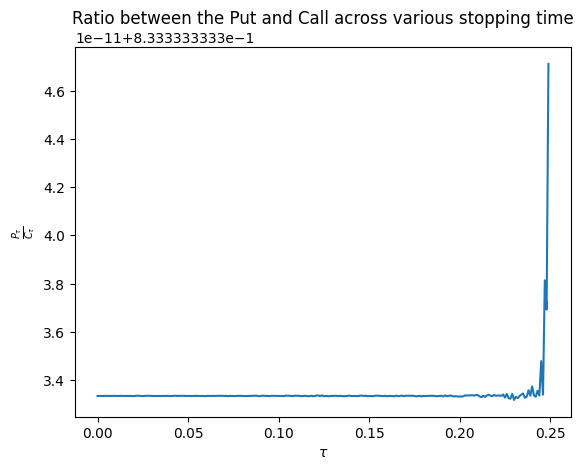

In [15]:
# Plot taus against alphas
plt.plot(tau, alphas)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\frac{P_{\tau}}{C_{\tau}}$')
plt.title('Ratio between the Put and Call across various stopping time')
plt.show()
None

Since our $S_0$ was given as 100, $\tau = 0$ does not exist.
Moreover, we only need to look at situations where the barrier is hit before expiration. Therefore $\tau = 0.25$
is also not under consideration.

As stock price is assumed a random process, we have no preconceived notion of what $\tau$ exactly is. Nevertheless
the graph above clearly shows that the ratio of $\frac{P_{\tau}}{C_{\tau}}$ is stabilized for possible $\tau$ values
in $(0, 0.25)$. This would mean that the gradient of the graph is 0 for all such $\tau$
(i.e., $\frac{\delta}{\delta \tau} \frac{P_{\tau}}{C_{\tau}} = 0$)

The above could be expressed as:

$$
\frac{\delta}{\delta \tau} \frac{P_{\tau}}{C_{\tau}} =
\frac{\delta}{\delta \tau} \frac{
95 \cdot \Phi\left[-\frac{\log(114) - \log(95)}{0.4 \sqrt{0.25 - \tau}}
+ 0.2\sqrt{0.25 - \tau}\right]
- 114 \cdot \Phi\left[-\frac{\log(114) - \log(95)}{0.4 \sqrt{0.25 - \tau}}
- 0.2\sqrt{0.25 - \tau}\right]
}
{
114 \cdot \Phi\left[\frac{\log(114) - \log(136.8)}{0.4 \sqrt{0.25 - \tau}}
+ 0.2\sqrt{0.25 - \tau}\right] - 136.8 \cdot \Phi\left[\frac{\log(114) - \log(136.8)}{0.4 \sqrt{0.25 - \tau}}
- 0.2\sqrt{0.25 - \tau}\right]
}
= 0
$$

If we think the above as analogous to the Greek $\Theta$:

$$
\frac{\delta}{\delta \tau} \frac{P_{\tau}}{C_{\tau}} =
-\frac{P_{\tau}}{C_{\tau}^2} \cdot \Theta_C + \frac{1}{C_{\tau}} \cdot \Theta_P =
0
$$

$$
\Leftrightarrow
\frac{1}{C_{\tau}} \cdot \Theta_P = \frac{P_{\tau}}{C_{\tau}^2} \cdot \Theta_C
$$

$$
\Leftrightarrow
\frac{P_{\tau}}{C_{\tau}} = \frac{\Theta_P}{\Theta_C}
$$

Knowing that in our case, due to 0 interest rate:

$$
\frac{\Theta_P}{\Theta_C} \propto
\frac{\Phi'\left[\frac{\log(114) - \log(95)}{0.4 \sqrt{0.25 - \tau}}
+ 0.2\sqrt{0.25 - \tau}\right]}
{
\Phi'\left[\frac{\log(114) - \log(136.8)}{0.4 \sqrt{0.25 - \tau}}
+ 0.2\sqrt{0.25 - \tau}\right]
}
$$

This can be analytically solved and approximated to $\alpha \approx 0.83$

With this, we can find the continuously monitored barrier put option value at time-0 as:

$$
P_0 - \alpha \times C_0
\approx 5.03
$$

# Problem 2

In [16]:
# uses the same GBMdynamics class as in Problem 1

In [17]:
class CallOption:
    
    def __init__(self, K, T, price=None):
        self.K = K
        self.T = T
        self.price = price

    def BSprice(self, dynamics):
        # ignores self.price if given, because this function calculates price based on the dynamics 
        
        F = dynamics.S*np.exp(dynamics.rGrow*self.T)
        sd = dynamics.sigma*np.sqrt(self.T)
        d1 = np.log(F/self.K)/sd+sd/2
        d2 = d1-sd
        return np.exp(-dynamics.r*self.T)*(F*norm.cdf(d1)-self.K*norm.cdf(d2))
    
    def IV(self, dynamics):
        # ignores dynamics.sigma, because this function solves for sigma.  
        
        if self.price is None: 
            raise ValueError('Contract price must be given')
    
        df = np.exp(-dynamics.r*self.T)  #discount factor
        F = dynamics.S / df
        lowerbound = np.max([0,(F-self.K)*df])
        C = self.price
        if C<lowerbound:
            return np.nan
        if C==lowerbound:
            return 0
        if C>=F*df:
            return np.nan 

        local_sigma = dynamics.sigma # saving the original sigma due to no "copy" method
        dytry = dynamics
        # We "try" values of sigma until we find sigma that generates price C

        # First find lower and upper bounds
        dytry.sigma = 0.2
        while self.BSprice(dytry)>C:
            dytry.sigma /= 2
        while self.BSprice(dytry)<C:
            dytry.sigma *= 2
        hi = dytry.sigma
        lo = hi/2
        # We have calculated "lo" and "hi" which bound the implied volatility from below and above. 
        # In other words, the implied volatility is somewhere in the interval [lo,hi].
        # Then, to calculate the implied volatility within that interval, 
        # for purposes of this homework, you may either (A) write your own bisection algorithm, 
        # or (B) use scipy.optimize.bisect or (C) use scipy.optimize.brentq
        # You will need to provide lo and hi to those solvers.
        # There are other solvers that do not require you to bound the solution 
        # from below and above (for instance, scipy.optimize.fsolve is a useful solver).  
        # However, if you are able to bound the solution (of a single-variable problem), 
        # then bisection or Brent will be more reliable.

        def f(x):
            dytry.update_sigma(x)
            return self.BSprice(dytry) - C

        impliedVolatility = brentq(f, lo, hi)   # you fill this in, using bisect or brentq imported from scipy.optimize,
                                 # or by writing your own bisection algorithm.

        dynamics.update_sigma(local_sigma) # restoring the original sigma
        return impliedVolatility


In [18]:
#Test the BSprice function
dynamics2 = GBMdynamics(sigma=0.4, rGrow=0, S=100, r=0)
contract2 = CallOption(K=100, T=0.5)
contract2.BSprice(dynamics2)

11.246291601828489

In [19]:
#Test the IV function
contract2.price = 12
contract2.IV(dynamics2)

0.4270054241126889

## (a)

In [20]:
contract_a1 = CallOption(K = 100, T = 0.5, price = 11.25)

In [21]:
print("The BS IV of the Call option with", contract_a1.T, "expiry:", contract_a1.IV(dynamics2))

The BS IV of the Call option with 0.5 expiry: 0.4001327809210663


In [22]:
contract_a2 = CallOption(K = 100, T = 1.0, price = 12.00)

In [23]:
print("The BS IV of the Call option with", contract_a2.T, "expiry:", contract_a2.IV(dynamics2))

The BS IV of the Call option with 1.0 expiry: 0.3019384309935543


## (b)

In [24]:
avg_IV = (contract_a1.IV(dynamics2) + contract_a2.IV(dynamics2))/2

In [25]:
dynamics_arithavg = GBMdynamics(sigma=avg_IV, rGrow=0, S=100, r=0)

In [26]:
contract_b = CallOption(K = 100, T = 0.75)

In [27]:
print("The BS price of the Call option with arithmetic average estimated IV:", contract_b.BSprice(dynamics_arithavg))

The BS price of the Call option with arithmetic average estimated IV: 12.081533286249247


## (c)

If we long 1 1.0-expiry call for cash settlement and short 1 0.75-expiry call for physical settlement, with the
above prices and dynamics, there is a **type-II** arbitrage.

To explain more:
- At time-0, the price we need to pay is $\approx 12.00 - 12.08 = -0.08$ (Negative cost at time-0).
- At time-0.75, if the call option is in-the-money, we receive $K$ and short $S_{0.75}$:
        - With physical settlement, at time-1, our payoff from the 0.75-expiry call becomes $K - S_{1}$
        - If the other call option is out-of-money, we receive nothing from the call but our payoff from the original
          settlement is non-negative ($K - S_{1} \geq 0$)
        - If the other call option is in-the-money, we receive $S_{1} - K$ in cash. If we are able to sell the share
          of stock from the original settlement in the frictionless market, our payoff becomes $K - S_{1} + S_{1} - K$
          which is $0$
- At time-0.75, if the call option is out-of-money, we receive $0$:
        - At time-1, the payoff from the other call option is, by definition, non-negative ($(S_{1} - K)^+ \geq 0$)

Therefore, since we have a negative cost at time-0, and a payoff of $\geq 0$ at time-1 with probability 1,
we have a type-II arbitrage.